In [1]:
import numpy as np
import os
from tqdm.notebook import tqdm
import matplotlib as mpl
from Bio import SeqIO, Phylo
import matplotlib.pyplot as plt
from Bio.Phylo.PhyloXML import Phylogeny
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio.Phylo.Consensus import *
from Bio import AlignIO
import pylab
import networkx as nx
import gc

np.random.seed(7)
gc.enable()
plt.style.use('seaborn-white')

In [2]:
# FastTree - works really fast, + bootstrap, results in wiered branch lengths
# Biopython - really slow consensus, and bootrsrap -> results in nice distances

In [3]:
NT = 1 # let's skip bootstaping for BioPython
per_genome_per_year = 1.947 * 10**-4 # (Cabrera V. M., 2021)
mtDNA_length = 16559

In [4]:
def read_mulitple_write_to_one(dirs=['Human/'],
                               output_file='unalaigned.fasta',
                               rename_after_file_name=True):

    all_records = []

    for directory in dirs:
        records = []
        for record in tqdm(os.listdir(directory)):
            records.append(SeqIO.read(directory + record, "fasta"))

        if rename_after_file_name:
            _ = [
                setattr(record, 'id',
                        name.replace('.fasta', '').replace(' ', '_'))
                for name, record in zip(os.listdir(directory), records)
            ]

        all_records.extend(records)

    SeqIO.write(all_records, output_file, "fasta")

    return read_mulitple_write_to_one

In [5]:
def run_mafft_docker_container(container_name='staphb/mafft',
                               settings_string = '--auto',
                               input_file = 'unalaigned.fasta',
                               output_file = 'alaigned.fasta'):
    # 0 non error exit
    return os.system(f"docker run --rm -v {os.getcwd()}:/data {container_name} mafft {settings_string} {input_file} > {output_file}")

In [6]:
def run_fasttree_docker_container(container_name='pegi3s/fasttree',
                               settings_string = '-boot 1000 -nt',
                               input_file = 'aligned.fasta',
                               output_file = 'output.tre'):
    # 0 non error exit
    return os.system(f'docker run --rm -v {os.getcwd()}:/data {container_name} bash -c "FastTree {settings_string} /data/{input_file} > /data/{output_file}"')

In [7]:
read_mulitple_write_to_one(dirs=['Human/'], output_file='unalaigned1.fasta')

  0%|          | 0/45 [00:00<?, ?it/s]

<function __main__.read_mulitple_write_to_one(dirs=['Human/'], output_file='unalaigned.fasta', rename_after_file_name=True)>

In [8]:
run_mafft_docker_container(input_file='unalaigned1.fasta',
                           output_file='alaigned1.fasta')

0

In [9]:
run_fasttree_docker_container(input_file='alaigned1.fasta',
                              settings_string = f'-boot {NT} -rawdist -gtr -nt', # -rawdist
                              output_file='tree1.tre')

0

In [15]:
def build_tree(msa='aligned.fasta',
               target_tree='tree.tre',
               outgroup='L1c1d_Central_African',
               n_trees=10):

    msa = AlignIO.read(msa, 'fasta')

    if not target_tree:
        
        #calculator = DistanceCalculator('identity')
        #dm = calculator.get_distance(msa)
        #constructor = DistanceTreeConstructor(method='nj')
        #tree = constructor.nj(dm)
        
        calculator = DistanceCalculator('identity')
        constructor = DistanceTreeConstructor(calculator, method='nj')
        trees = bootstrap_trees(msa, n_trees, constructor)
        #tree = get_support(target_tree, trees, len_trees=n_trees)
        tree = majority_consensus(trees, cutoff=0.7)

    else:
        tree = Phylo.read(target_tree, "newick")


    if outgroup:
        tree.root_with_outgroup(outgroup)

    tree.ladderize()
    
    K = [1]
    for node in tree.get_nonterminals():
        if not node.name:
            
            K[0]+=1
            node.name = 'Inner'+str(K[0])

    return tree

In [16]:
def draw_tree(tree, title, figsize=(28, 21), axvspan=(0, 0)):

    tree = Phylogeny.from_tree(tree)

    md = np.median([
        path.branch_length for path in tree.get_nonterminals()
        if path.branch_length
    ])

    for path in tree.get_nonterminals():
        if path.branch_length:
            path.branch_length = min(min(np.log1p(path.branch_length),
                                     np.log1p(md)+np.log1p(path.branch_length)**0.1), 0.002)

    colors = {}

    md = np.median([
        leaf.branch_length for leaf in tree.get_terminals()
        if leaf.branch_length
    ])
    for leaf in tree.get_terminals():
        leaf.branch_length = min(np.log1p(leaf.branch_length), np.log1p(md))

        if leaf.name[0] in colors.keys():
            leaf.color = colors[leaf.name[0]]
        else:
            colors[leaf.name[0]] = mpl.colors.cnames[list(
                mpl.colors.cnames.keys())[np.random.randint(
                    0,
                    len(mpl.colors.cnames.keys()) - 1)]]
            leaf.color = colors[leaf.name[0]]

    plt.rcParams["figure.figsize"] = figsize
    mpl.rcParams['lines.linewidth'] = 2
    mpl.rcParams["font.size"] = 21
            
    def label_function(x):
        if '_' in str(x):
            return str(x).replace('_', ' ').split()[0]
        elif 'Inner' in str(x):
            return str(x).replace('Inner','IN')
        return x.split()[0]

    fig = plt.subplot()

    Phylo.draw(tree,
               axes=fig,
               label_func=lambda x: label_function(x),
               do_show=False,
               axvspan=axvspan)

    fig.set_title(title, fontsize=38)
    fig.set_xlabel('rescaled branch length')

    fig.autoscale()

    plt.tight_layout()
    plt.show()

    return draw_tree

In [17]:
outgroup1 = 'L1c1d_Central_African'

tree1 = build_tree('alaigned1.fasta',
                    None,
                    outgroup='L1c1d_Central_African',
                    n_trees=NT)


terminals1 = [t.name for t in tree1.get_terminals()]

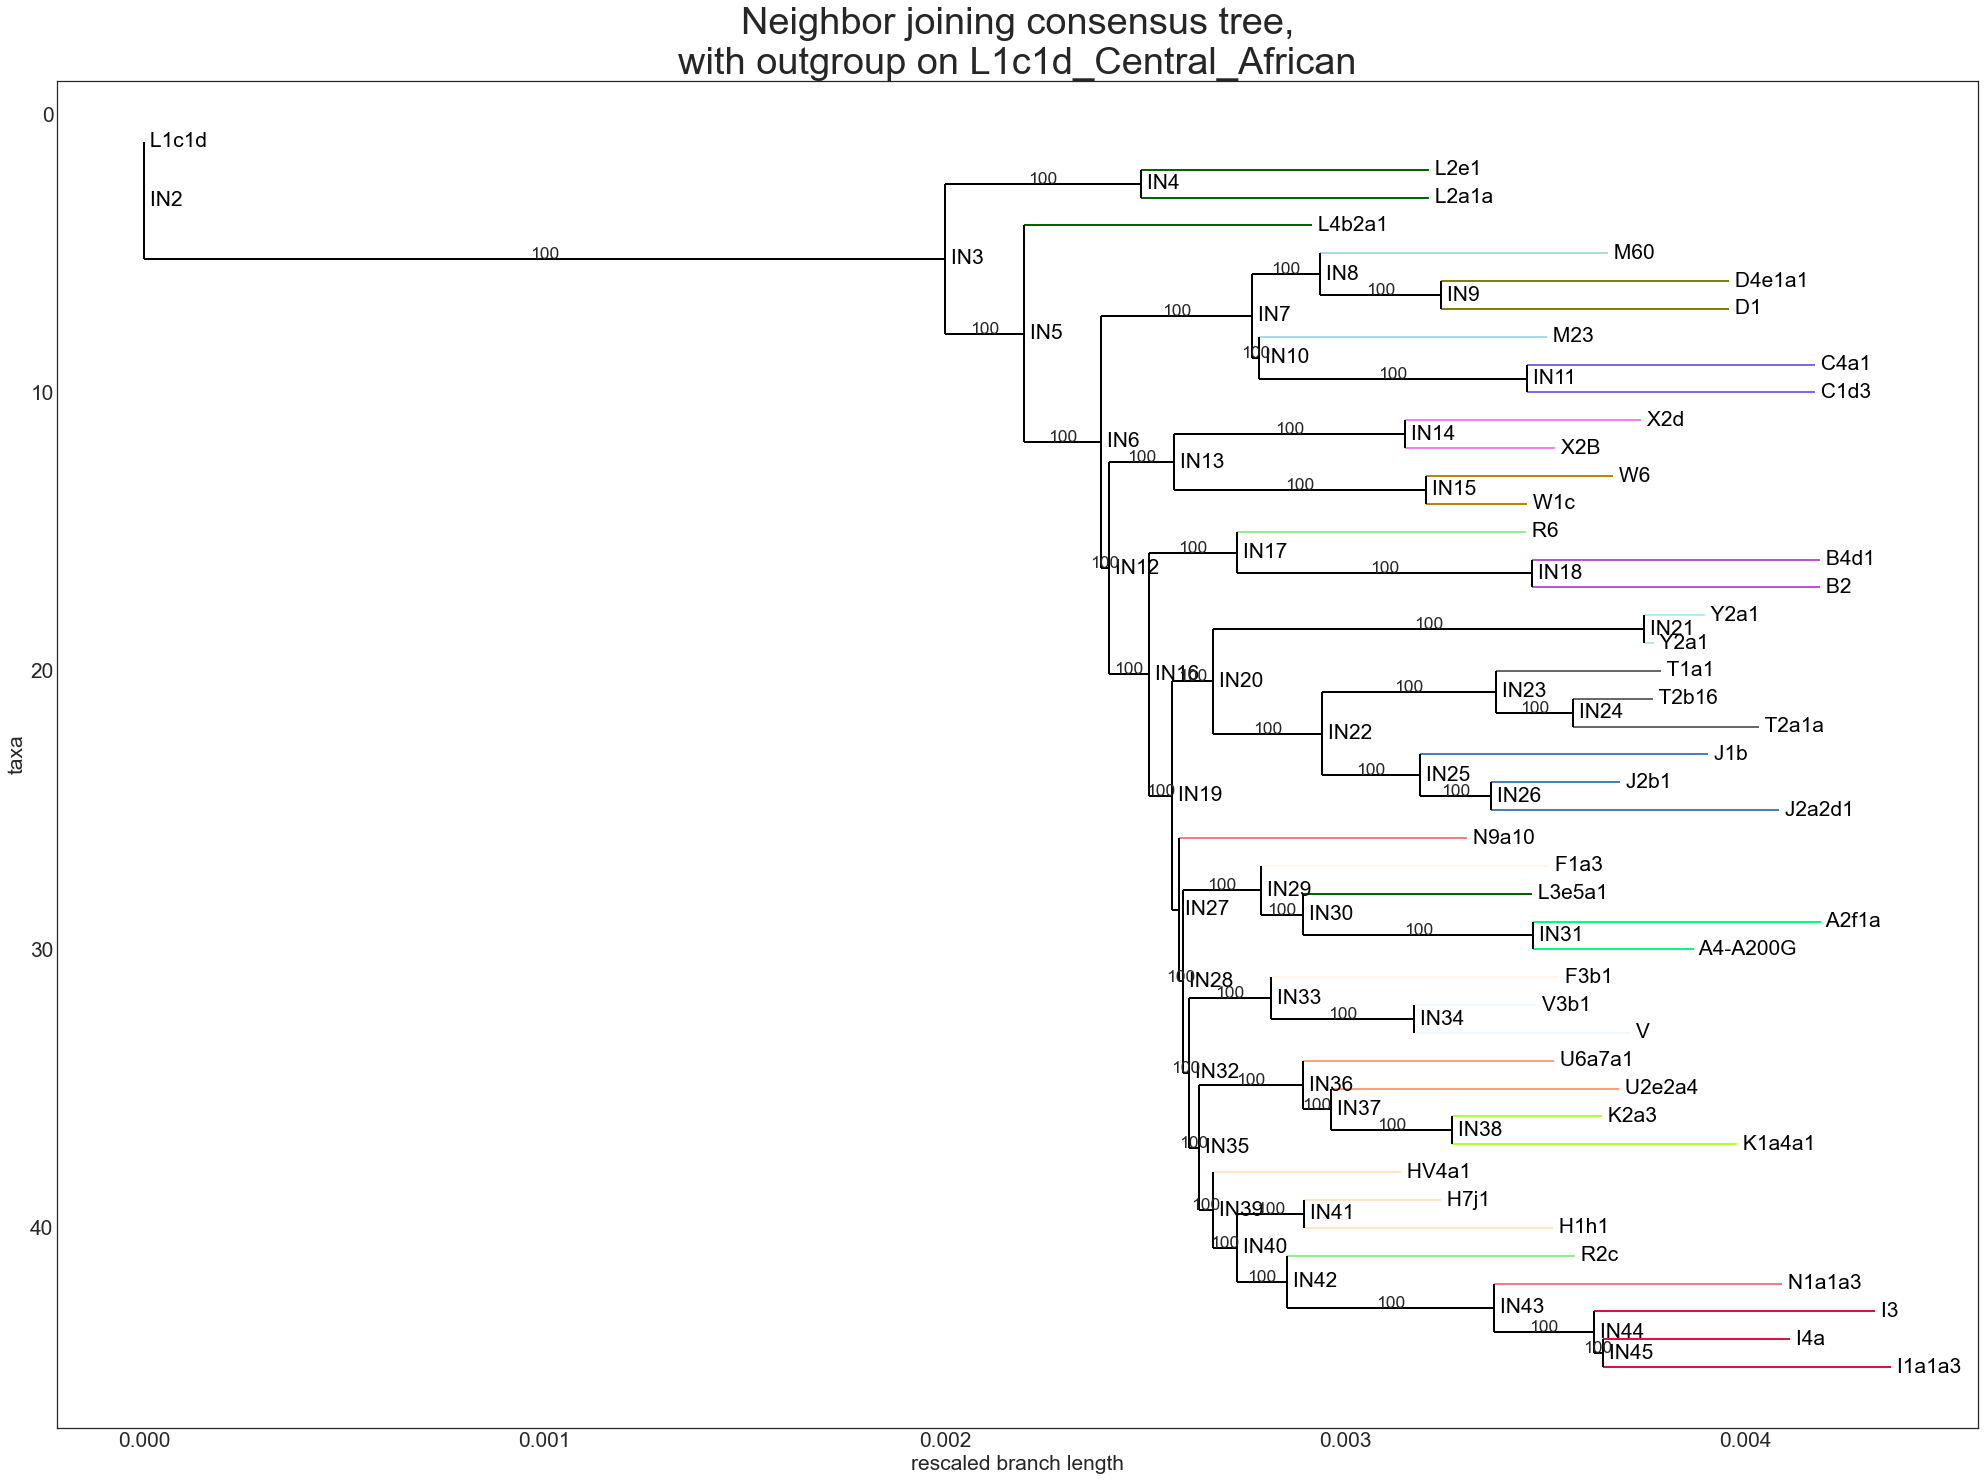

<function __main__.draw_tree(tree, title, figsize=(28, 21), axvspan=(0, 0))>

In [18]:
draw_tree(tree1, f'Neighbor joining consensus tree,\nwith outgroup on {outgroup1}')

In [19]:
def get_constant_years_from_identity(tree, a, b):

    for node in tree.nodes:
        if str(node).strip() == a:
            a = node
        elif str(node) == b:
            b = node

    path = nx.shortest_path(tree, a, b)
    #print(f'from {a} -> {b} through {[p.name for p in path[1:-1]]}')
    return sum([p.branch_length/2
                for p in path[1:-1]]) * mtDNA_length / per_genome_per_year

In [20]:
tree1 = Phylo.to_networkx(tree1)

In [21]:
d = []
for t in terminals1:
    try:
        d.append(get_constant_years_from_identity(tree1, 'Inner2', t))
    except:
        pass

np.mean([dd for dd in d if dd > 0])

189969.8773837197

In [22]:
d = []
for t in terminals1:
    try:
        d.append(get_constant_years_from_identity(tree1, 'Inner5', t))
    except:
        pass
np.mean([dd for dd in d if dd > 0])

43175.55452501035

In [23]:
read_mulitple_write_to_one(
    dirs=['Human/', 'Neanderthal/', 'Denisova/', 'Pan/'],
    output_file='unalaigned2.fasta')

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

<function __main__.read_mulitple_write_to_one(dirs=['Human/'], output_file='unalaigned.fasta', rename_after_file_name=True)>

In [24]:
run_mafft_docker_container(input_file='unalaigned2.fasta',
                           output_file='alaigned2.fasta')

0

In [25]:
run_fasttree_docker_container(input_file='alaigned2.fasta',
                              settings_string = f'-boot {NT} -nt',
                              output_file='tree2.tre')

0

In [26]:
outgroup2 = ['NC_001643.1_Pan_troglodytes', 'D38116.1_Pan_paniscus']
tree2 = build_tree('alaigned2.fasta', None, outgroup=outgroup2, n_trees=NT)

terminals2 = [t.name for t in tree2.get_terminals()]

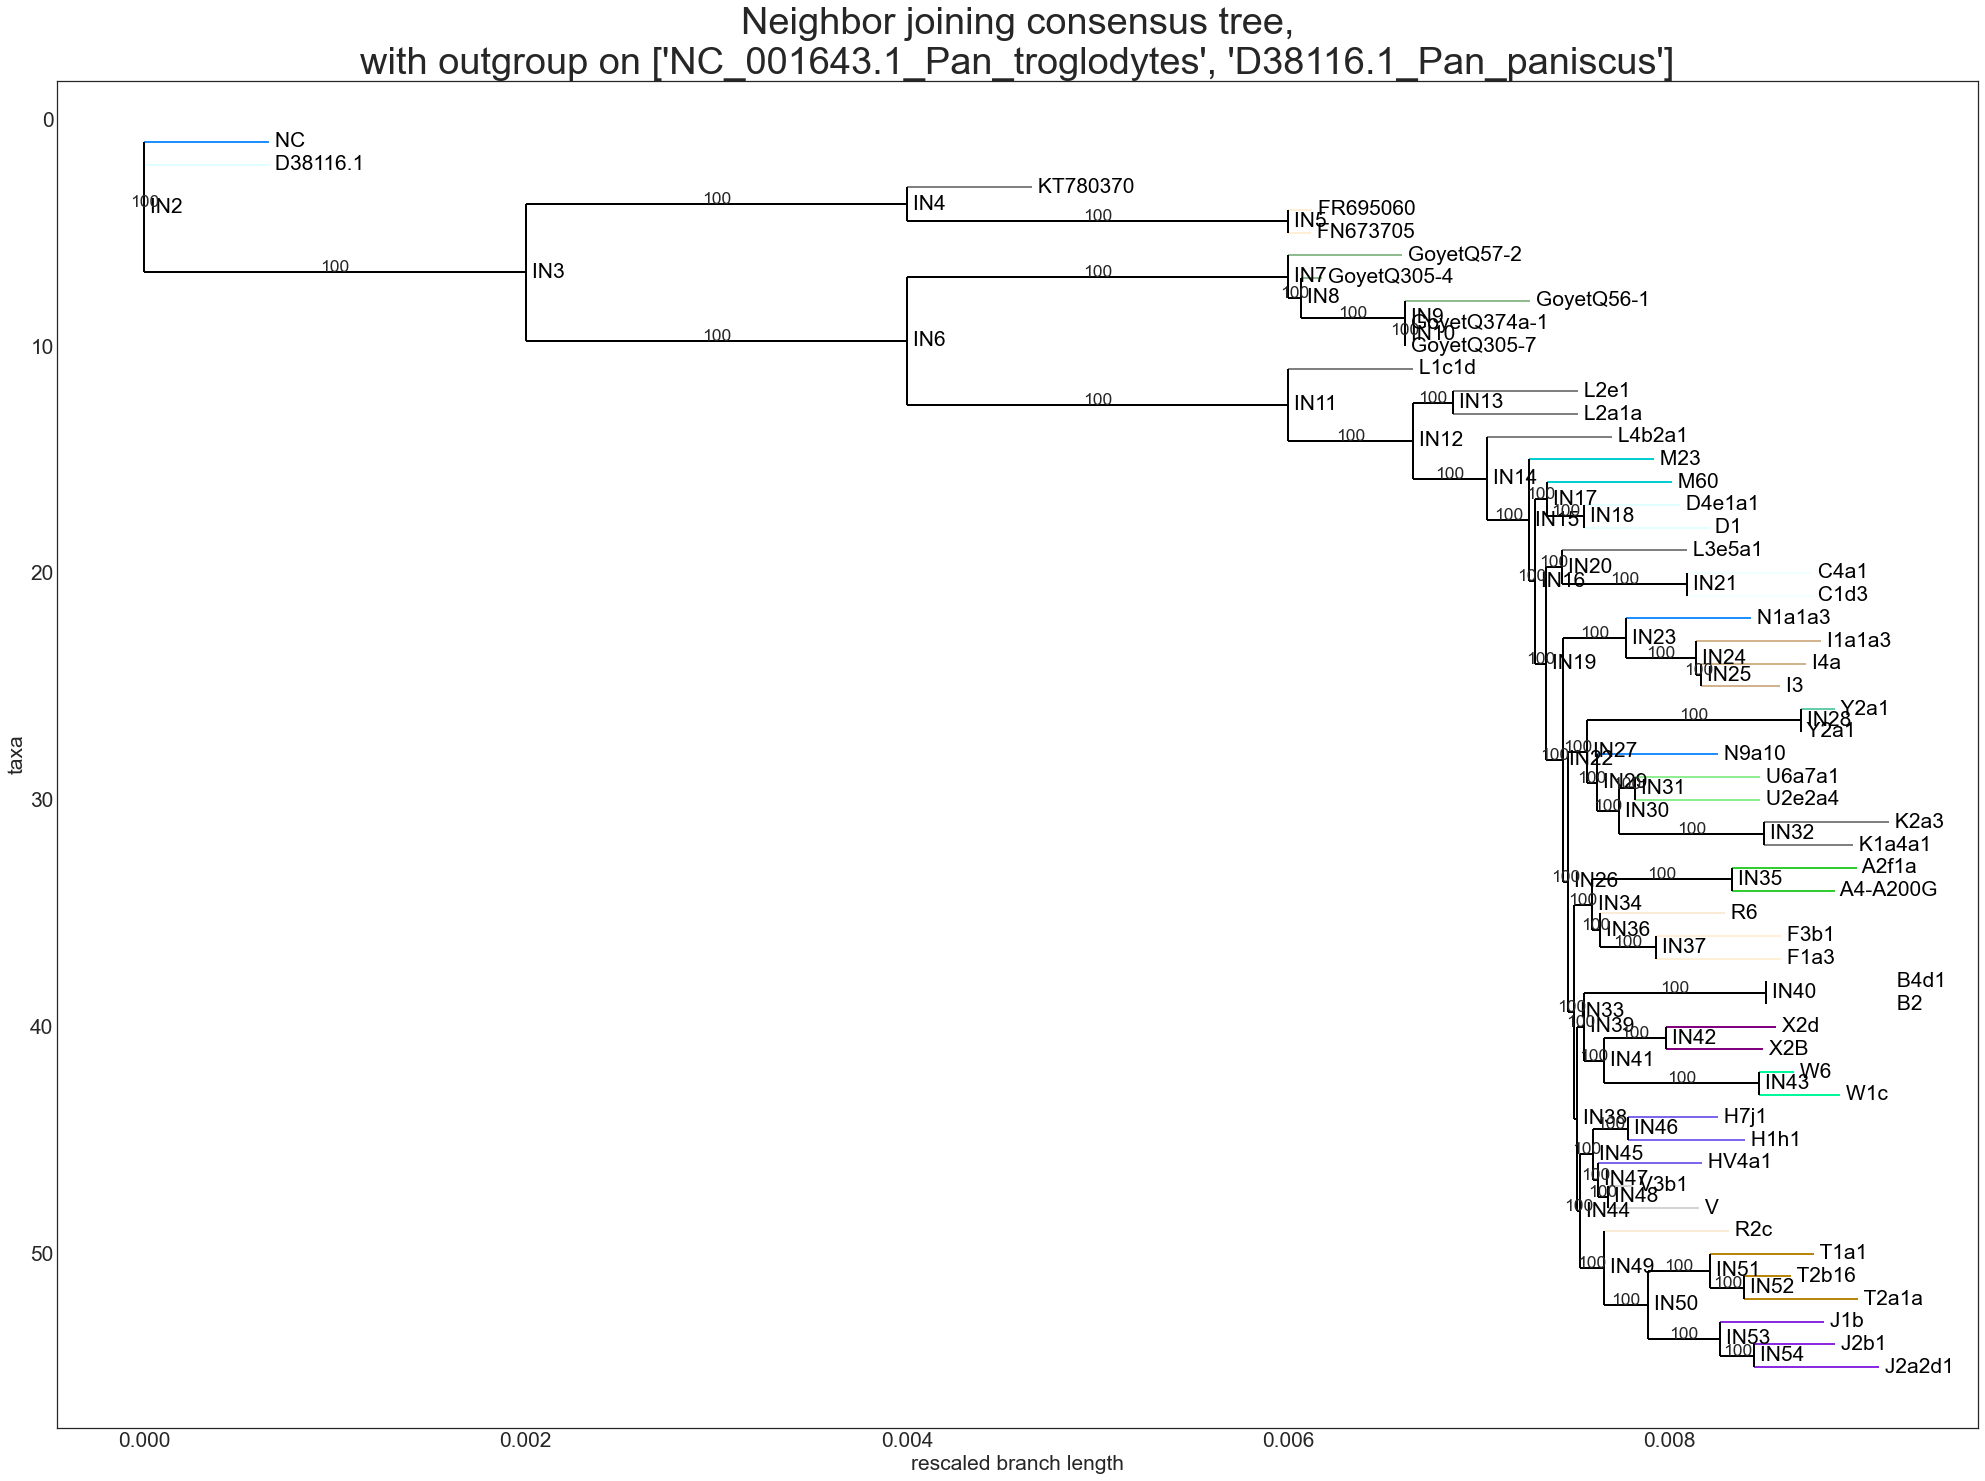

<function __main__.draw_tree(tree, title, figsize=(28, 21), axvspan=(0, 0))>

In [27]:
draw_tree(
    tree2,
    f'Neighbor joining consensus tree,\nwith outgroup on {outgroup2}')

In [28]:
tree2 = Phylo.to_networkx(tree2)

In [29]:
d = []
for t in terminals1[10:]:
    try:
        d.append(get_constant_years_from_identity(tree2, 'Inner3', t))
    except:
        pass
np.mean([dd for dd in d if dd > 0])

519369.77210530307

1. Kinene T. [et al]. Rooting Trees, Methods for // Encyclopedia of Evolutionary Biology [Online]. URL: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7149615/.

2. Archives: mtDNA Stories // haplogroup.org [Online]. URL: https://haplogroup.org/mtdna/.

3. Cabrera V. M. Human molecular evolutionary rate, time dependency and transient polymorphism effects viewed through ancient and modern mitochondrial DNA genomes // Scientific Reports [Online]. URL: https://doi.org/10.1038/s41598-021-84583-1.

4. Thomson J. Humans did come out of Africa, says DNA // Nature [Online]. URL: https://doi.org/10.1038/news001207-8.